In [1]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/AMZN2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

In [2]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [3]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [4]:
amzn_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
amzn_closing_all = np.reshape(amzn_closing_all, (amzn_closing_all.shape[0], -1))
amzn_closing_all.shape

(1200, 1)

In [5]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(amzn_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [8]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size+1,len(train)):
    train_x.append(scaled_data[i-history_size:i,0] - scaled_data[i-history_size-1:i-1,0])
    train_y.append(scaled_data[i,0] - scaled_data[i-1,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1], 1))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0] - scaled_data[i-history_size-1:i-1,0])
    test_y.append(scaled_data[i,0] - scaled_data[i-1,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1], 1))
print(test_x.shape)

(939, 60, 1)
(200, 60, 1)


In [9]:
# How many features do we want to pass as hidden unit
UNITS = range(2, 60, 2)
K = 5
model = None
gc.collect()

best_unit_count = None
# Best Validation Error
best_err = sys.maxsize

for unit_count in UNITS:
    kf = KFold(n_splits=K, random_state=None, shuffle=False)
    y_err = []
    
    
    # Cross Validaiton
    for train_index, val_index in kf.split(train_x):
        X_train, X_val = train_x[train_index], train_x[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
    
        model = Sequential()
        model.add(LSTM(units=unit_count, return_sequences=True, input_shape=(train_x.shape[1],train_x.shape[2])))
        model.add(Flatten())
        model.add(Dense(unit_count))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
        y_hat = model.predict(X_val).transpose()[0]
        del model
        gc.collect()
        
        y_err.append(rmse(y_hat, y_val))
        
    print(str(unit_count), "mean val RMSE:", np.mean(y_err))

    if np.mean(y_err) < best_err:
        best_err = np.mean(y_err)
        best_unit_count = unit_count

print(best_unit_count, best_err)

2 mean val RMSE: 0.009999128833731894
4 mean val RMSE: 0.010070897670866896
6 mean val RMSE: 0.010222989139493141
8 mean val RMSE: 0.010358551889286156
10 mean val RMSE: 0.010045496850078167
12 mean val RMSE: 0.010158116165433804
14 mean val RMSE: 0.010138981814984592
16 mean val RMSE: 0.010243617486194883
18 mean val RMSE: 0.010196786073392576
20 mean val RMSE: 0.010264010569386134
22 mean val RMSE: 0.010448549258887588
24 mean val RMSE: 0.010335591246202053
26 mean val RMSE: 0.010510601894854768
28 mean val RMSE: 0.010426237485885921
30 mean val RMSE: 0.010076691773666074
32 mean val RMSE: 0.010409039879083572
34 mean val RMSE: 0.0101256086285436
36 mean val RMSE: 0.010073702946171968
38 mean val RMSE: 0.010323158233634906
40 mean val RMSE: 0.010142452433317241
42 mean val RMSE: 0.010251333421352052
44 mean val RMSE: 0.010336369848142245
46 mean val RMSE: 0.010255737562806266
48 mean val RMSE: 0.010184515764793548
50 mean val RMSE: 0.01031559077476556
52 mean val RMSE: 0.010134680029

In [10]:
model = None
gc.collect()

model = Sequential()
model.add(LSTM(units=best_unit_count, return_sequences=True, input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Flatten())
model.add(Dense(best_unit_count))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=1000, batch_size=16, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/1000
59/59 [==============================] - 0s 3ms/step - loss: 1.1545e-04
Epoch 2/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.1406e-04
Epoch 3/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1467e-04
Epoch 4/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1461e-04
Epoch 5/1000
59/59 [==============================] - 0s 4ms/step - loss: 1.1560e-04
Epoch 6/1000
59/59 [==============================] - 0s 5ms/step - loss: 1.1638e-04
Epoch 7/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1598e-04
Epoch 8/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1153e-04
Epoch 9/1000
59/59 [==============================] - 0s 6ms/step - loss: 1.1282e-04
Epoch 10/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.1268e-04
Epoch 11/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.1294e-04
Epoch 12/1000
59/59 [==============================] - 0s 8ms/s

59/59 [==============================] - 0s 3ms/step - loss: 1.0401e-04
Epoch 97/1000
59/59 [==============================] - 0s 4ms/step - loss: 1.0189e-04
Epoch 98/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0315e-04
Epoch 99/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0296e-04
Epoch 100/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0144e-04
Epoch 101/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0514e-04
Epoch 102/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0376e-04
Epoch 103/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0140e-04
Epoch 104/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0110e-04
Epoch 105/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0294e-04
Epoch 106/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0229e-04
Epoch 107/1000
59/59 [==============================] - 0s 8m

59/59 [==============================] - 0s 8ms/step - loss: 1.0207e-04
Epoch 191/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0079e-04
Epoch 192/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0063e-04
Epoch 193/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0237e-04
Epoch 194/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0107e-04
Epoch 195/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0210e-04
Epoch 196/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0096e-04
Epoch 197/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0087e-04
Epoch 198/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0104e-04
Epoch 199/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0250e-04
Epoch 200/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0216e-04
Epoch 201/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 6ms/step - loss: 1.0246e-04
Epoch 285/1000
59/59 [==============================] - 0s 6ms/step - loss: 1.0308e-04
Epoch 286/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.9951e-05
Epoch 287/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0017e-04
Epoch 288/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0083e-04
Epoch 289/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0057e-04
Epoch 290/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0109e-04
Epoch 291/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0039e-04
Epoch 292/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0402e-04
Epoch 293/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0239e-04
Epoch 294/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0070e-04
Epoch 295/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 1.0049e-04
Epoch 379/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0002e-04
Epoch 380/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.9692e-05
Epoch 381/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0064e-04
Epoch 382/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.8703e-05
Epoch 383/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0094e-04
Epoch 384/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0029e-04
Epoch 385/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0076e-04
Epoch 386/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.9682e-05
Epoch 387/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0126e-04
Epoch 388/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.9739e-05
Epoch 389/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 5ms/step - loss: 9.8956e-05
Epoch 473/1000
59/59 [==============================] - 0s 7ms/step - loss: 9.9116e-05
Epoch 474/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.7843e-05
Epoch 475/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.8666e-05
Epoch 476/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.8475e-05
Epoch 477/1000
59/59 [==============================] - 0s 7ms/step - loss: 9.8092e-05
Epoch 478/1000
59/59 [==============================] - 0s 3ms/step - loss: 9.8050e-05
Epoch 479/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0052e-04
Epoch 480/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.8818e-05
Epoch 481/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.8241e-05
Epoch 482/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.7769e-05
Epoch 483/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 9.2671e-05
Epoch 567/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.4435e-05
Epoch 568/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.3300e-05
Epoch 569/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.3481e-05
Epoch 570/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.2782e-05
Epoch 571/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.2504e-05
Epoch 572/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.1804e-05
Epoch 573/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.2373e-05
Epoch 574/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.6978e-05
Epoch 575/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.2539e-05
Epoch 576/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.2137e-05
Epoch 577/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 4ms/step - loss: 8.7702e-05
Epoch 661/1000
59/59 [==============================] - 0s 6ms/step - loss: 8.9358e-05
Epoch 662/1000
59/59 [==============================] - 0s 7ms/step - loss: 8.6908e-05
Epoch 663/1000
59/59 [==============================] - 0s 7ms/step - loss: 8.7315e-05
Epoch 664/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.7268e-05
Epoch 665/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.6837e-05
Epoch 666/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.6852e-05
Epoch 667/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.6566e-05
Epoch 668/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.8653e-05
Epoch 669/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.6327e-05
Epoch 670/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.6690e-05
Epoch 671/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 8.5473e-05
Epoch 755/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.3933e-05
Epoch 756/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.2965e-05
Epoch 757/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.3695e-05
Epoch 758/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.3679e-05
Epoch 759/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.5658e-05
Epoch 760/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.4823e-05
Epoch 761/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.6868e-05
Epoch 762/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.5441e-05
Epoch 763/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.5873e-05
Epoch 764/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.5368e-05
Epoch 765/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 8.1784e-05
Epoch 849/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.2957e-05
Epoch 850/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.1943e-05
Epoch 851/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.2431e-05
Epoch 852/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.2889e-05
Epoch 853/1000
59/59 [==============================] - 0s 4ms/step - loss: 8.5382e-05
Epoch 854/1000
59/59 [==============================] - 0s 3ms/step - loss: 8.2981e-05
Epoch 855/1000
59/59 [==============================] - 0s 5ms/step - loss: 8.1365e-05
Epoch 856/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.3201e-05
Epoch 857/1000
59/59 [==============================] - 0s 6ms/step - loss: 8.4178e-05
Epoch 858/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.1914e-05
Epoch 859/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 8.3728e-05
Epoch 943/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.0972e-05
Epoch 944/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.0504e-05
Epoch 945/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.0490e-05
Epoch 946/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.0283e-05
Epoch 947/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.1352e-05
Epoch 948/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.1430e-05
Epoch 949/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.2883e-05
Epoch 950/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.2351e-05
Epoch 951/1000
59/59 [==============================] - 0s 7ms/step - loss: 8.1166e-05
Epoch 952/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.2210e-05
Epoch 953/1000
59/59 [==============================] - 0s

20602

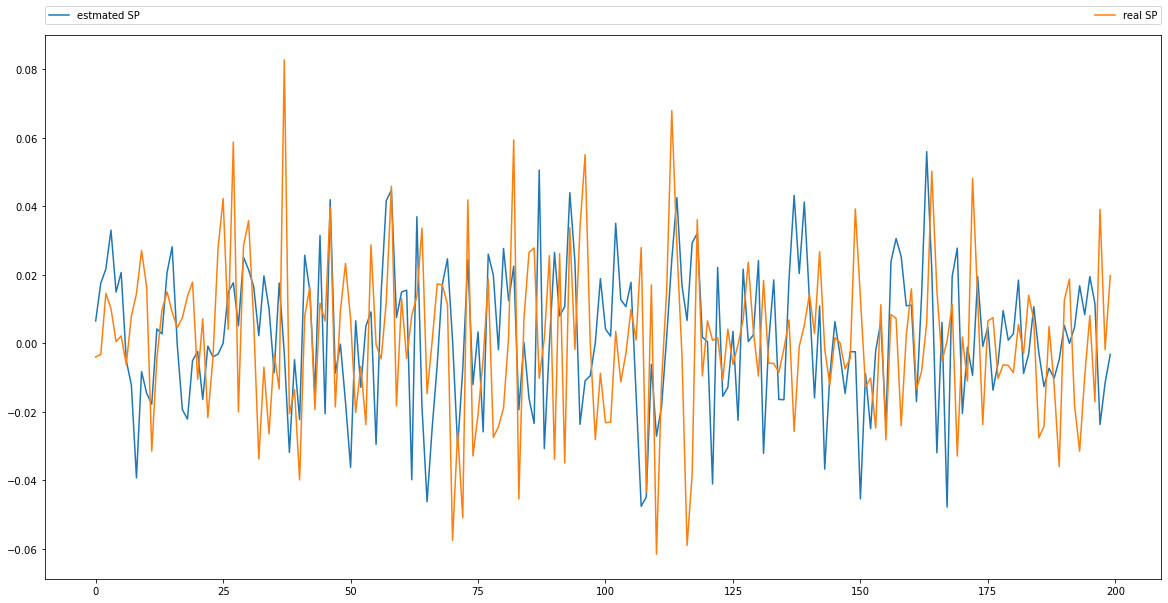

In [11]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [12]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.022841058332265792
RMSE:  0.02878785403009591


In [13]:
model = None
gc.collect()

3382

In [14]:
model = None
gc.collect()

model = Sequential()
model.add(LSTM(units=36, return_sequences=True, input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Flatten())
model.add(Dense(36))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=1000, batch_size=16, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/1000
59/59 [==============================] - 0s 4ms/step - loss: 1.3725e-04
Epoch 2/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1847e-04
Epoch 3/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1436e-04
Epoch 4/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1096e-04
Epoch 5/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1499e-04
Epoch 6/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1155e-04
Epoch 7/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0894e-04
Epoch 8/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1050e-04
Epoch 9/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1759e-04
Epoch 10/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0668e-04
Epoch 11/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0533e-04
Epoch 12/1000
59/59 [==============================] - 0s 8ms/s

59/59 [==============================] - 0s 8ms/step - loss: 1.0168e-04
Epoch 97/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0368e-04
Epoch 98/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0152e-04
Epoch 99/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0214e-04
Epoch 100/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0433e-04
Epoch 101/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0335e-04
Epoch 102/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0178e-04
Epoch 103/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0202e-04
Epoch 104/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0173e-04
Epoch 105/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0142e-04
Epoch 106/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0206e-04
Epoch 107/1000
59/59 [==============================] - 0s 8m

59/59 [==============================] - 0s 8ms/step - loss: 1.0142e-04
Epoch 191/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0135e-04
Epoch 192/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0294e-04
Epoch 193/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0153e-04
Epoch 194/1000
59/59 [==============================] - 0s 4ms/step - loss: 1.0233e-04
Epoch 195/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0256e-04
Epoch 196/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0279e-04
Epoch 197/1000
59/59 [==============================] - 0s 5ms/step - loss: 1.0298e-04
Epoch 198/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0209e-04
Epoch 199/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0107e-04
Epoch 200/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0255e-04
Epoch 201/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 1.0274e-04
Epoch 285/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0514e-04
Epoch 286/1000
59/59 [==============================] - 0s 3ms/step - loss: 1.0175e-04
Epoch 287/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0106e-04
Epoch 288/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0074e-04
Epoch 289/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0266e-04
Epoch 290/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0197e-04
Epoch 291/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0218e-04
Epoch 292/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0184e-04
Epoch 293/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0104e-04
Epoch 294/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0092e-04
Epoch 295/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 1.0101e-04
Epoch 379/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0193e-04
Epoch 380/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0232e-04
Epoch 381/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0204e-04
Epoch 382/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0147e-04
Epoch 383/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0247e-04
Epoch 384/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0264e-04
Epoch 385/1000
59/59 [==============================] - 0s 4ms/step - loss: 1.0250e-04
Epoch 386/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0137e-04
Epoch 387/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0174e-04
Epoch 388/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0338e-04
Epoch 389/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 6ms/step - loss: 1.0111e-04
Epoch 473/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0145e-04
Epoch 474/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0229e-04
Epoch 475/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0358e-04
Epoch 476/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0178e-04
Epoch 477/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0202e-04
Epoch 478/1000
59/59 [==============================] - 0s 6ms/step - loss: 1.0062e-04
Epoch 479/1000
59/59 [==============================] - 0s 5ms/step - loss: 1.0050e-04
Epoch 480/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0231e-04
Epoch 481/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0337e-04
Epoch 482/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0158e-04
Epoch 483/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 4ms/step - loss: 1.0027e-04
Epoch 567/1000
59/59 [==============================] - 0s 6ms/step - loss: 1.0178e-04
Epoch 568/1000
59/59 [==============================] - 0s 3ms/step - loss: 1.0153e-04
Epoch 569/1000
59/59 [==============================] - 0s 3ms/step - loss: 9.9755e-05
Epoch 570/1000
59/59 [==============================] - 0s 2ms/step - loss: 1.0193e-04
Epoch 571/1000
59/59 [==============================] - 0s 2ms/step - loss: 1.0072e-04
Epoch 572/1000
59/59 [==============================] - 0s 2ms/step - loss: 1.0187e-04
Epoch 573/1000
59/59 [==============================] - 0s 3ms/step - loss: 1.0147e-04
Epoch 574/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0042e-04
Epoch 575/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0201e-04
Epoch 576/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0073e-04
Epoch 577/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 9.9987e-05
Epoch 661/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0018e-04
Epoch 662/1000
59/59 [==============================] - 0s 6ms/step - loss: 9.9970e-05
Epoch 663/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0083e-04
Epoch 664/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0111e-04
Epoch 665/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.9881e-05
Epoch 666/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0061e-04
Epoch 667/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0182e-04
Epoch 668/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.9904e-05
Epoch 669/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.9944e-05
Epoch 670/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0049e-04
Epoch 671/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 9.3660e-05
Epoch 755/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.5436e-05
Epoch 756/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.3907e-05
Epoch 757/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.3050e-05
Epoch 758/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.3945e-05
Epoch 759/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.3194e-05
Epoch 760/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.3477e-05
Epoch 761/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.4246e-05
Epoch 762/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.3731e-05
Epoch 763/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.4094e-05
Epoch 764/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.2914e-05
Epoch 765/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 2ms/step - loss: 9.0172e-05
Epoch 849/1000
59/59 [==============================] - 0s 2ms/step - loss: 9.2157e-05
Epoch 850/1000
59/59 [==============================] - 0s 3ms/step - loss: 9.1698e-05
Epoch 851/1000
59/59 [==============================] - 0s 7ms/step - loss: 9.0624e-05
Epoch 852/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.9626e-05
Epoch 853/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.1081e-05
Epoch 854/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.8546e-05
Epoch 855/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.0422e-05
Epoch 856/1000
59/59 [==============================] - 0s 8ms/step - loss: 9.1014e-05
Epoch 857/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.9318e-05
Epoch 858/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.9401e-05
Epoch 859/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 8.7955e-05
Epoch 943/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.5893e-05
Epoch 944/1000
59/59 [==============================] - 0s 4ms/step - loss: 8.5617e-05
Epoch 945/1000
59/59 [==============================] - 0s 7ms/step - loss: 8.5106e-05
Epoch 946/1000
59/59 [==============================] - 0s 7ms/step - loss: 8.4955e-05
Epoch 947/1000
59/59 [==============================] - 0s 7ms/step - loss: 8.4520e-05
Epoch 948/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.4637e-05
Epoch 949/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.5926e-05
Epoch 950/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.5623e-05
Epoch 951/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.4701e-05
Epoch 952/1000
59/59 [==============================] - 0s 8ms/step - loss: 8.4308e-05
Epoch 953/1000
59/59 [==============================] - 0s

20602

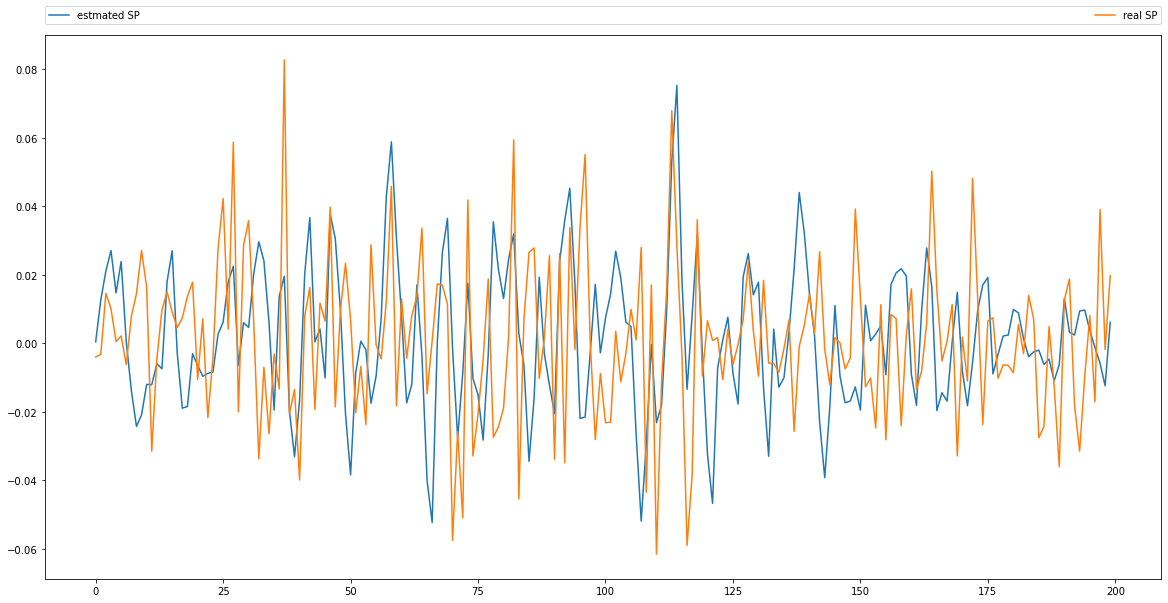

In [15]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [16]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.022220903073236244
RMSE:  0.02791633713519078


In [17]:
model = None
gc.collect()

3384

In [18]:
def true_count(y_hat, test_y):
    res = 0
    for (a,b) in zip(y_hat, test_y):
        if (a * b > 0):
            res += 1
        elif a == b == 0:
            res += 1
    return res
            
true_count(y_hat, test_y)

107